In [1]:
import gzip
from collections import defaultdict
import random
from tqdm import tqdm
import numpy as np
import ast
import string
from nltk.stem.porter import *
from sklearn.linear_model import LogisticRegression

In [4]:
def readJSON(path):
    for l in gzip.open(path, 'rt', encoding="utf8"):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u,g,d

In [5]:
def parseData(path):
    for l in gzip.open(path, 'rt', encoding="utf8"):
        yield eval(l)
dataset = list(parseData("train_Category.json.gz"))

In [6]:
train = dataset[:165000]
valid = dataset[165000:]

In [7]:
wordCount = defaultdict(int)
totalWords = 0
punct = string.punctuation
stemmer = PorterStemmer()

In [8]:
for d in train:
    t = d['text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        #w = stemmer.stem(w)
        totalWords += 1
        wordCount[w] += 1

In [9]:
counts = [(wordCount[w], w) for w in wordCount]

In [10]:
counts.sort()
counts.reverse()

In [11]:
def feature(datum):
    feat = [0]*len(wordSet)
    t = datum['text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if not (w in wordSet): continue
        feat[wordId[w]] += 1
    feat.append(1)
    return feat

In [12]:
y_train = [d['genreID'] for d in train]
y_valid = [d['genreID'] for d in valid]

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
size_list = [2800 + 200 * n for n in range(16)]
C_list = [0.1, 1, 10]

In [15]:
print(size_list)

[2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800]


In [16]:
accuracies = []
for C in C_list:
    for size in tqdm(size_list):
        words = [w[1] for w in counts[:size]]
        wordId = dict(zip(words, range(len(words))))
        wordSet = set(words)
        X_train = [feature(d) for d in train]
        X_valid = [feature(d) for d in valid]
        model = LogisticRegression(C=C)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        accuracy = sum(1 for a, b in zip(y_valid, preds) if a == b) / len(y_valid)
        accuracies.append([accuracy, C, size])

100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [2:21:56<00:00, 532.28s/it]


In [17]:
%store accuracies

Stored 'accuracies' (list)


In [18]:
file_name = 'accuracies.npy'
np.save(file_name, np.array(accuracies))

In [2]:
accuracies = np.load('accuracies.npy')

In [3]:
accuracies[accuracies[:, 0].argsort()][-15:]

array([[7.186e-01, 1.000e+00, 5.400e+03],
       [7.189e-01, 1.000e+01, 4.400e+03],
       [7.192e-01, 1.000e+00, 4.800e+03],
       [7.193e-01, 1.000e+01, 5.000e+03],
       [7.193e-01, 1.000e+00, 4.400e+03],
       [7.196e-01, 1.000e-01, 5.600e+03],
       [7.197e-01, 1.000e-01, 5.200e+03],
       [7.198e-01, 1.000e+01, 5.200e+03],
       [7.205e-01, 1.000e+01, 5.600e+03],
       [7.228e-01, 1.000e+01, 5.400e+03],
       [7.233e-01, 1.000e+01, 4.600e+03],
       [7.236e-01, 1.000e-01, 5.800e+03],
       [7.241e-01, 1.000e+01, 5.800e+03],
       [7.244e-01, 1.000e+00, 5.600e+03],
       [7.260e-01, 1.000e+00, 5.800e+03]])

**Observations:** The top accuracies are obtained by size=5800 and C=1  
Performance plotted below.

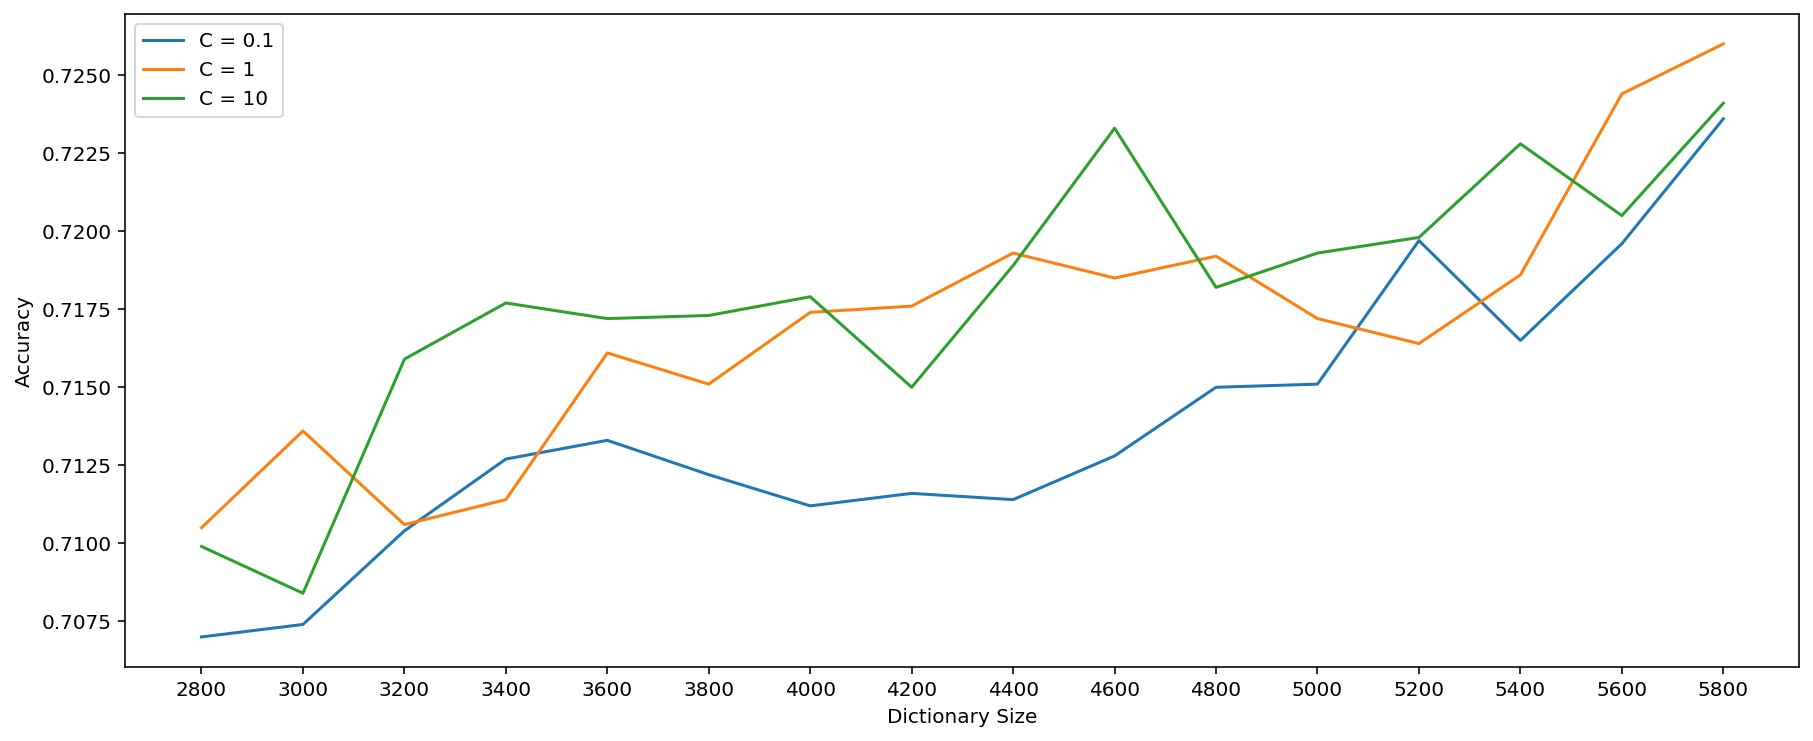

In [10]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.figure(figsize=(15,6))
x1 = [a[2] for a in accuracies if a[1] == 0.1]
y1 = [a[0] for a in accuracies if a[1] == 0.1]
x2 = [a[2] for a in accuracies if a[1] == 1]
y2 = [a[0] for a in accuracies if a[1] == 1]
x3 = [a[2] for a in accuracies if a[1] == 10]
y3 = [a[0] for a in accuracies if a[1] == 10]
size_list = [2800 + 200 * n for n in range(16)]

plt.plot(x1, y1, label='C = 0.1')
plt.plot(x2, y2, label='C = 1')
plt.plot(x3, y3, label='C = 10')
plt.xticks(size_list, [str(s) for s in size_list])
plt.xlabel("Dictionary Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()